In [1]:
import numpy as np
import json

from local.caching import load, save, save_exists

with open("./cache/meta_rxns.json") as j:
    meta_rxns = json.load(j)
LEN_RXN = len(meta_rxns)

class Numerizer:
    def __init__(self, lst: list[str]=list()) -> None:
        if not isinstance(lst, list): lst = list(lst)
        self._encoding: dict[str, int] = dict((s, i) for i, s in enumerate(lst))
        self._decoding: list[str] = lst

    def Encode(self, s: str):
        if s not in self._encoding:
            self._encoding[s] = len(self._encoding)
            self._decoding.append(s)
        return self._encoding[s]
    
    def Decode(self, i: int):
        return self._decoding[i]
    
    def __len__(self):
        return len(self._encoding)
    
# encoding = Numerizer(meta_rxns)

enc:Numerizer = load("enc")
lst = [""]*len(enc._decoding)
for k, i in enc._encoding.items():
    lst[i] = k
enc._decoding = lst

recovering & decompressing cached data from [{WORKSPACE}/main/biocyc_run/cache/enc.pkl.gz]


In [2]:
gq_sorted = load("gq_ss")
gq_sorted.shape

recovering & decompressing cached data from [{WORKSPACE}/main/biocyc_run/cache/gq_ss.pkl.gz]


(2701414, 7)

In [4]:
save_name = "gq_dist_mat"
redo = False
# redo = True

if not redo and save_exists(save_name):
    sqmat, mat = load(save_name)
    mat_enc = load(f"{save_name}-enc")
    
else:
    rxns = set()
    min_dq = 9999
    max_dq = 0
    mat_enc = Numerizer()
    for ia, ib, dq, gq, c, adq, agq in gq_sorted:
        a, b = (enc.Decode(int(x)) for x in [ia, ib])
        # print(a, b)
        mat_enc.Encode(a)
        mat_enc.Encode(b)
        min_dq = min(agq, min_dq)
        max_dq = max(agq, max_dq)

    # no_data_penalty = max_d*2
    print(len(mat_enc), min_dq, max_dq)

    mat = np.zeros(shape=(len(mat_enc), len(mat_enc)))
    for ia, ib, dq, gq, c, adq, agq in gq_sorted:
        a, b = (enc.Decode(int(x)) for x in [ia, ib])
        
        ja, jb = (mat_enc.Encode(x) for x in [a, b])
        mat[ja, jb] = agq
        mat[jb, ja] = agq

    sqmat = 1 - mat/max_dq # score to dist
    sqmat = sqmat*sqmat # squared dists
    print(mat.shape)

    save(save_name, (sqmat, mat), compression_level=5)
    save(f"{save_name}-enc", mat_enc)

2981 1.9536463697077646 77.61408272242468
(2981, 2981)
compressing & caching data to [{WORKSPACE}/main/biocyc_run/cache/gq_dist_mat.pkl.gz]
compressing & caching data to [{WORKSPACE}/main/biocyc_run/cache/gq_dist_mat-enc.pkl.gz]


/home/tony/Utilities/mambaforge/envs/445/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/tony/Utilities/mambaforge/envs/445/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


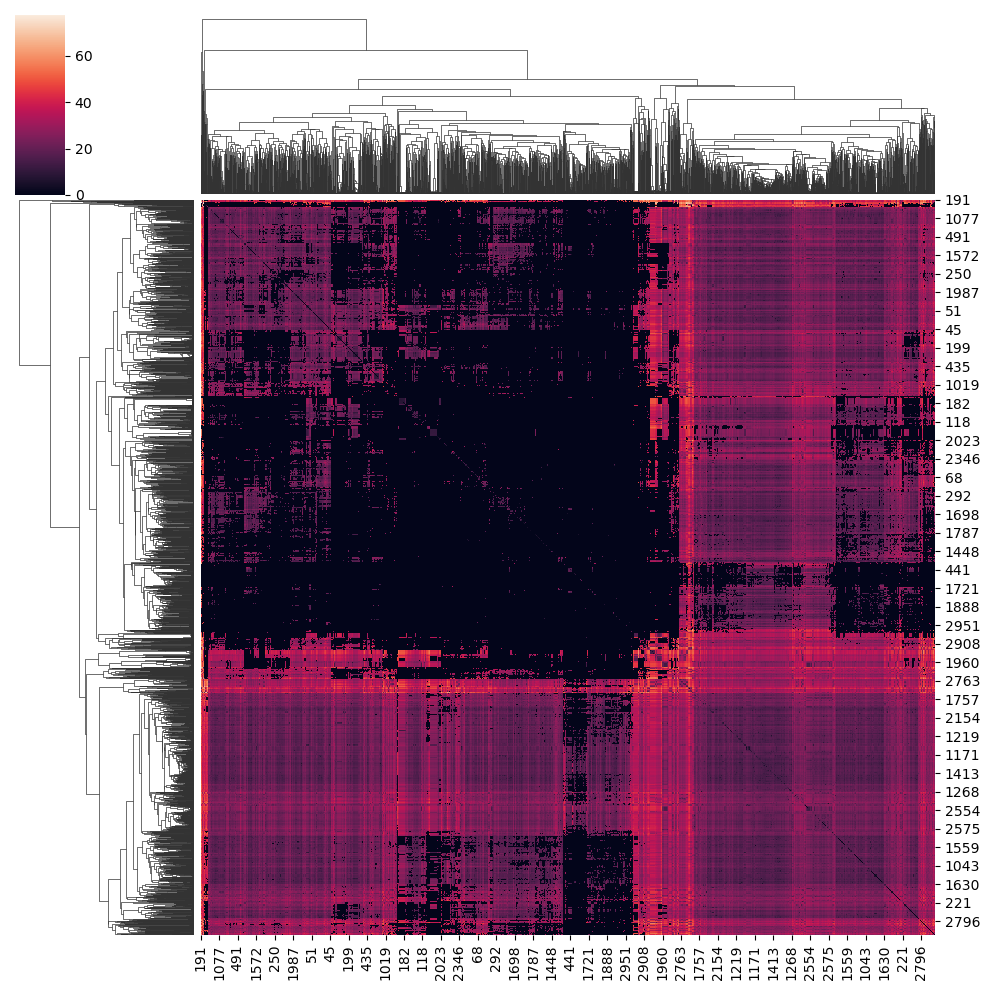

In [5]:
import seaborn as sns

sns.clustermap(mat)